# Enhancing Tomographic Image Classification with Transfer Learning and Small VGG-based Model

## Importing Libraries:

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import os
import cv2 as cv
import pathlib
import matplotlib.pyplot as plt
import random

In [2]:
# !pip install opencv-python

     --------------------------------------- 38.2/38.2 MB 27.3 MB/s eta 0:00:00


In [13]:
import matplotlib.pyplot as plt
def plot_image(url):
    img = cv.imread(url, cv.IMREAD_UNCHANGED)
    print("original shape: ",img.shape) 

    height, width = img.shape[:2]
    res = cv.resize(img,(224,224))
    #print("resized shape: ",res.shape)
    res= res/255.
    #print(res)
    plt.imshow(res)

original shape:  (1014, 1014, 3)


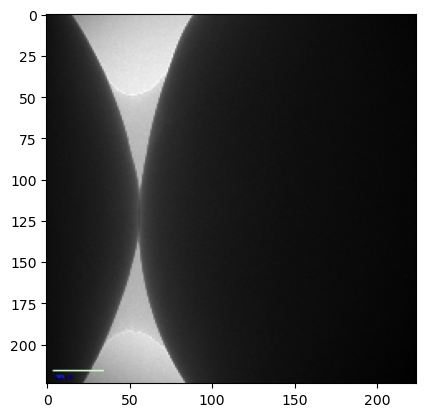

In [14]:
# Ploting one of intact images:
plot_image('./images/train/intact/test1_b_Export0001.jpg')


original shape:  (1014, 1014, 3)


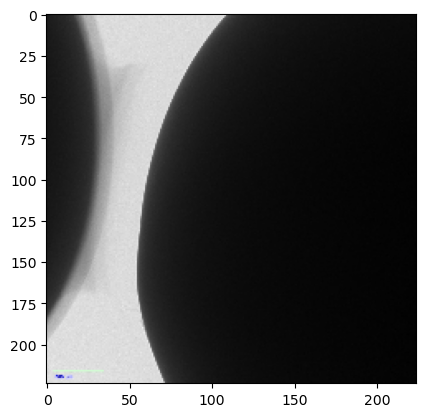

In [15]:
# Plotting one of broken images
plot_image('./images/train/broken/jpgtest1_Export0037.jpg')

In [10]:
#Turning tif format to jpg format

# import cv2, os
# base_path = "./images/intact/"
# new_path = "./images/intact/jpg/"
# for infile in os.listdir(base_path):
#     print ("file : " + infile)
#     if infile == ".DS_Store" or infile[-3:] == "bmp" or infile == "jpg":
#         continue
#     read = cv2.imread(base_path + infile)
#     outfile = infile.split('.')[0] + '.jpg'
#     cv2.imwrite(new_path+outfile,read,[int(cv2.IMWRITE_JPEG_QUALITY), 200])

## Use os.walk to find number of broken, and intact images for training and testing

In [17]:
import os

# Walk through pizza_steak directory and list number of files
for dirpath, dirnames, filenames in os.walk("images"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in 'images'.
There are 2 directories and 0 images in 'images\test'.
There are 0 directories and 7 images in 'images\test\broken'.
There are 0 directories and 11 images in 'images\test\intact'.
There are 2 directories and 0 images in 'images\train'.
There are 0 directories and 55 images in 'images\train\broken'.
There are 0 directories and 97 images in 'images\train\intact'.


In [18]:
# number of broken images for training
train_broken_num = len(os.listdir("images/train/broken"))
train_broken_num

55

In [19]:
# number of intact images for training 
train_intact_num = len(os.listdir("images/train/intact"))
train_intact_num

97

In [20]:
# Number of broken images for testing
test_broken_num = len(os.listdir("images/test/broken"))
test_broken_num

7

In [21]:
# nzmber of intact images for testing
test_intact_num = len(os.listdir("images/test/intact"))
test_intact_num

11

In [23]:
# Get the class names (programmatically, this is much more helpful with a longer list of classes)
data_dir = pathlib.Path("images/train/") # turn our training path into a Python path
class_names = np.array(sorted([item.name for item in data_dir.glob('*')])) # created a list of class_names from the subdirectories
print(class_names)

['broken' 'intact']


In [28]:
# funtion bor plotting randomly form training images
def show_random_img(isBroken= True):
    dir_ = "broken" if isBroken == True else "intact"
    random_image = random.sample(os.listdir('./images/train/' +  dir_), 1)
    #print('./images/train/' +  dir_ + '/' + random_image[0])
    img = cv.imread('./images/train/' +  dir_ + '/' + random_image[0] , cv.IMREAD_UNCHANGED)
    #print("original shape: ",img.shape) #(215, 215, 4)

    height, width = img.shape[:2]
    res = cv.resize(img,(224,224))
    #print("resized shape: ",res.shape)
    res= res/255.
    #print(res)
    plt.imshow(res)

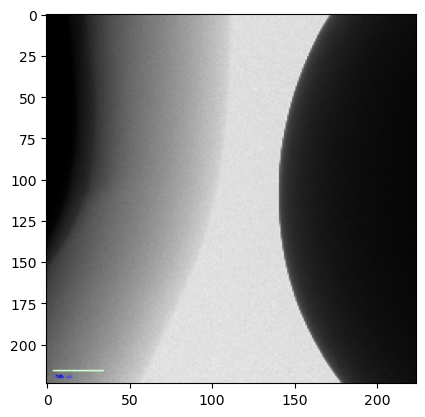

In [30]:
show_random_img(isBroken= True)


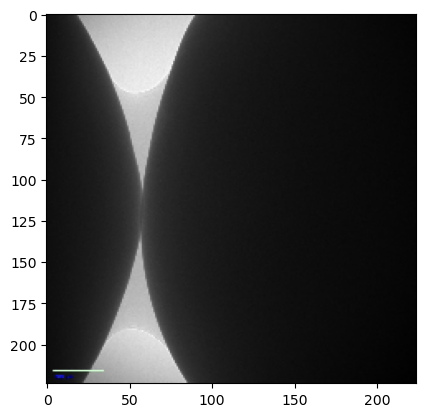

In [31]:
show_random_img(isBroken= False)

In [34]:
# Importing images using ImageDataGenerator and use data augmentation for training images
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set the seed
tf.random.set_seed(42)

# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1/255.,
                                             rotation_range=20, # rotate the image slightly between 0 and 20 degrees (note: this is an int not a float)
                                             shear_range=0.2, # shear the image
                                             zoom_range=0.2, # zoom into the image
                                             width_shift_range=0.2, # shift the image width ways
                                             height_shift_range=0.2, # shift the image height ways
                                             horizontal_flip=True) # flip the image on the horizontal axis
valid_datagen = ImageDataGenerator(rescale=1./255)

# Setup the train and test directories
train_dir = "images/train/"
test_dir = "images/test/"

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=10, # number of images to process at a time 
                                               target_size=(224, 224), # convert all images to be 224 x 224
                                               class_mode="binary", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(test_dir,
                                               batch_size=10,
                                               target_size=(224, 224),
                                               class_mode="binary",
                                               seed=42)

Found 152 images belonging to 2 classes.
Found 18 images belonging to 2 classes.


In [35]:
# model1 creation 
# Create a CNN model (same as Tiny VGG )

model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3, # can also be (3, 3)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=2, # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

In [36]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [37]:
# Compile the model
model_1.compile(loss="binary_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=20,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/20
16/16 [==============================] - 9s 487ms/step - loss: 0.6600 - accuracy: 0.6645 - val_loss: 0.5674 - val_accuracy: 0.7778
Epoch 2/20
16/16 [==============================] - 7s 433ms/step - loss: 0.5768 - accuracy: 0.7434 - val_loss: 0.4969 - val_accuracy: 0.8333
Epoch 3/20
16/16 [==============================] - 7s 444ms/step - loss: 0.5209 - accuracy: 0.7632 - val_loss: 0.4116 - val_accuracy: 0.8333
Epoch 4/20
16/16 [==============================] - 7s 441ms/step - loss: 0.4218 - accuracy: 0.8158 - val_loss: 0.3121 - val_accuracy: 0.8889
Epoch 5/20
16/16 [==============================] - 7s 441ms/step - loss: 0.4877 - accuracy: 0.7895 - val_loss: 0.3003 - val_accuracy: 0.9444
Epoch 6/20
16/16 [==============================] - 7s 449ms/step - loss: 0.3802 - accuracy: 0.8421 - val_loss: 0.2727 - val_accuracy: 0.8333
Epoch 7/20
16/16 [==============================] - 7s 443ms/step - loss: 0.3589 - accuracy: 0.8355 - val_loss: 0.2190 - val_accuracy: 0.9444
Epoch 

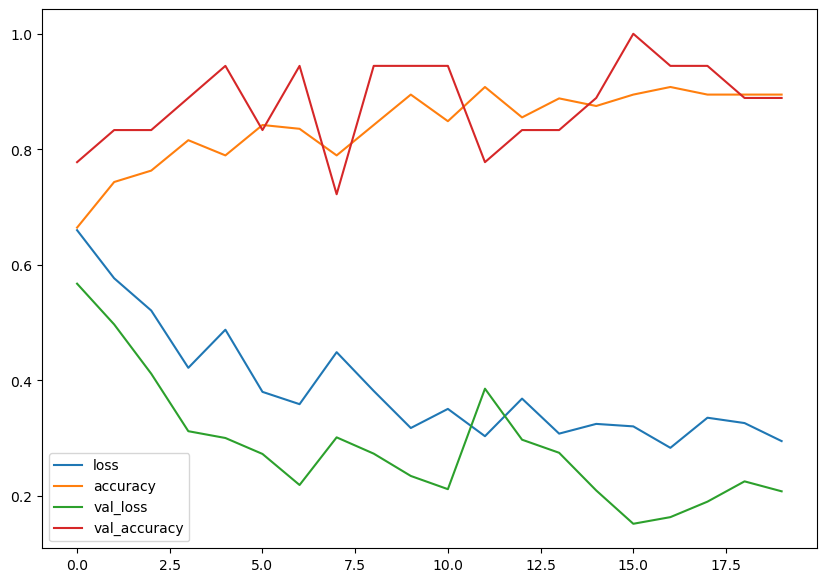

In [38]:
# Plot the training curves
import pandas as pd
pd.DataFrame(history_1.history).plot(figsize=(10, 7));

# Transfer Learning

In [39]:
# installing ten
# !pip install tensorflow_hub

In [40]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers
     

In [41]:
#use transfer learning: feature extraction
# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"


In [42]:
def create_model(model_url, num_classes=1):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=(224,224,3)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(1, activation='sigmoid', name='output_layer') # create our own output layer      
  ])

  return model

In [43]:
# Create model
resnet_model = create_model(resnet_url, num_classes=2)

# Compile
resnet_model.compile(loss='binary_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])

In [44]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 1)                 2049      
                                                                 
Total params: 23,566,849
Trainable params: 2,049
Non-trainable params: 23,564,800
_________________________________________________________________


In [45]:

# Fit the model
resnet_history = resnet_model.fit(train_data,
                                  epochs=10,
                                  steps_per_epoch=len(train_data),
                                  validation_data=valid_data,
                                  validation_steps=len(valid_data)) 

Epoch 1/10
16/16 [==============================] - 18s 721ms/step - loss: 0.7927 - accuracy: 0.5658 - val_loss: 0.7224 - val_accuracy: 0.6667
Epoch 2/10
16/16 [==============================] - 10s 641ms/step - loss: 0.4785 - accuracy: 0.7829 - val_loss: 0.4212 - val_accuracy: 0.7778
Epoch 3/10
16/16 [==============================] - 11s 657ms/step - loss: 0.3729 - accuracy: 0.8618 - val_loss: 0.2844 - val_accuracy: 0.8889
Epoch 4/10
16/16 [==============================] - 11s 654ms/step - loss: 0.3075 - accuracy: 0.9079 - val_loss: 0.2544 - val_accuracy: 0.8889
Epoch 5/10
16/16 [==============================] - 11s 682ms/step - loss: 0.2644 - accuracy: 0.9013 - val_loss: 0.2207 - val_accuracy: 0.8889
Epoch 6/10
16/16 [==============================] - 11s 676ms/step - loss: 0.2587 - accuracy: 0.9145 - val_loss: 0.1513 - val_accuracy: 1.0000
Epoch 7/10
16/16 [==============================] - 11s 685ms/step - loss: 0.2361 - accuracy: 0.9145 - val_loss: 0.1447 - val_accuracy: 0.9444

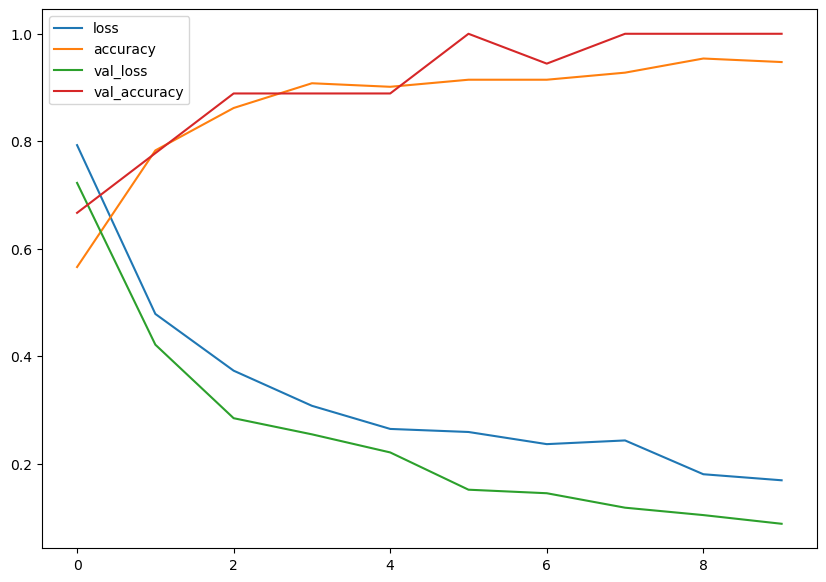

In [46]:
# Plot the training curves
import pandas as pd
pd.DataFrame(resnet_history.history).plot(figsize=(10, 7));

In [49]:
# making a list out of validation data
testlist_data = []
testlist_label=[]

for item in range(len(valid_data)):
        #print(valid_data.next()[0].shape)
        data = valid_data.next()
        testlist_data.append(data[0])
        testlist_label.append(data[1])
testlist_label = [i for item in testlist_label for i in item ]
testlist_data = [i for item in testlist_data for i in item ]

In [57]:
"""
this function shows the probability of each predicted class, if the probability is above 50 percent,
then it blongs to the intact class
else it blongs to the broken class
"""
def probability_function(model):
    for i in  range(len(testlist_data)):
        print("---------------------------------------------------------")
        
        plt.imshow(testlist_data[i])
        plt.show()
        test = tf.expand_dims(testlist_data[i], axis=0)
        pred = model.predict(test)
        pred_class = class_names[int(tf.round(pred)[0][0])]
        real_class = class_names[int(tf.round(testlist_label[i]))]
        print(f"the true class is: {real_class} and the predicted class is: {pred_class}, and probability is: {pred[0][0] * 100} percent")
        print("---------------------------------------------------------")

---------------------------------------------------------


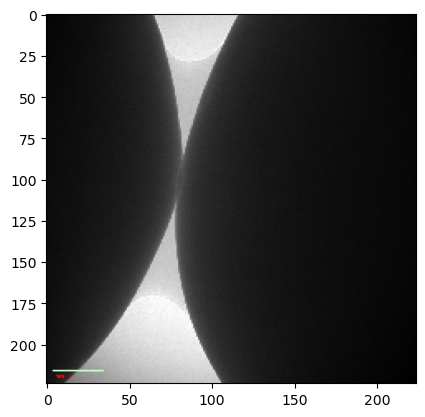

1/1 [==============================] - 0s 103ms/step
the true class is: intact and the predicted class is: intact, and probability is: 91.0740613937378 percent
---------------------------------------------------------
---------------------------------------------------------


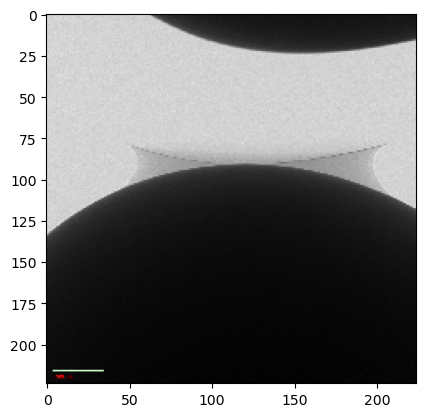

1/1 [==============================] - 0s 105ms/step
the true class is: broken and the predicted class is: broken, and probability is: 10.871219635009766 percent
---------------------------------------------------------
---------------------------------------------------------


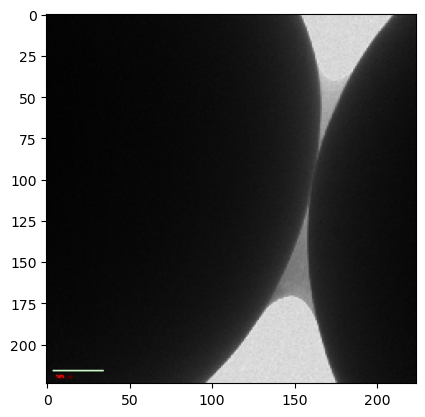

1/1 [==============================] - 0s 107ms/step
the true class is: intact and the predicted class is: intact, and probability is: 90.54409265518188 percent
---------------------------------------------------------
---------------------------------------------------------


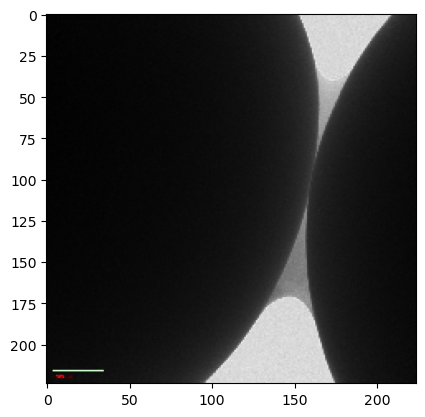

1/1 [==============================] - 0s 110ms/step
the true class is: intact and the predicted class is: intact, and probability is: 90.30076861381531 percent
---------------------------------------------------------
---------------------------------------------------------


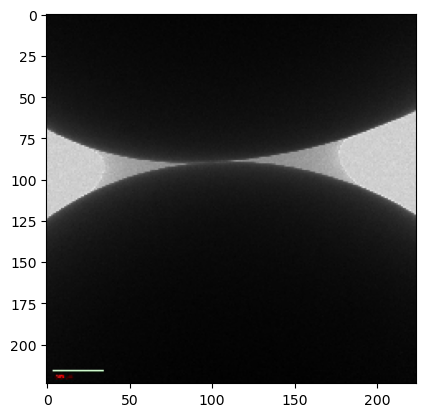

1/1 [==============================] - 0s 102ms/step
the true class is: intact and the predicted class is: intact, and probability is: 98.32454919815063 percent
---------------------------------------------------------
---------------------------------------------------------


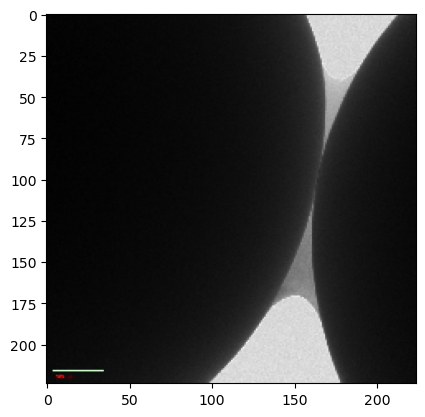

1/1 [==============================] - 0s 108ms/step
the true class is: intact and the predicted class is: intact, and probability is: 88.6767566204071 percent
---------------------------------------------------------
---------------------------------------------------------


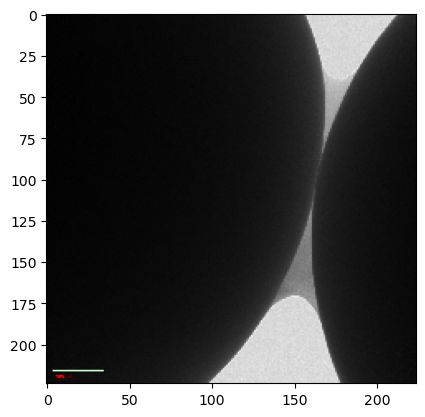

1/1 [==============================] - 0s 113ms/step
the true class is: intact and the predicted class is: intact, and probability is: 89.49833512306213 percent
---------------------------------------------------------
---------------------------------------------------------


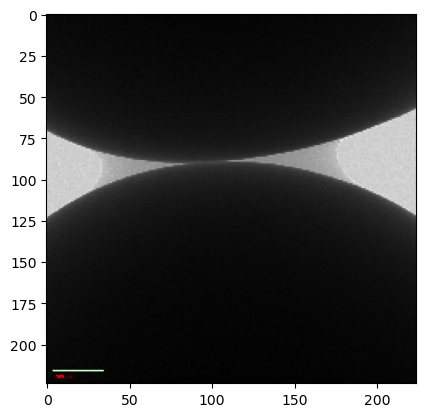

1/1 [==============================] - 0s 98ms/step
the true class is: intact and the predicted class is: intact, and probability is: 97.85916805267334 percent
---------------------------------------------------------
---------------------------------------------------------


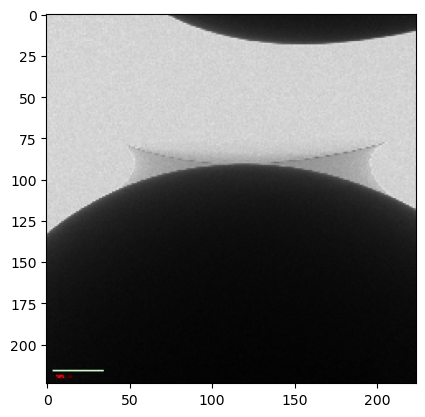

1/1 [==============================] - 0s 106ms/step
the true class is: broken and the predicted class is: broken, and probability is: 5.901815369725227 percent
---------------------------------------------------------
---------------------------------------------------------


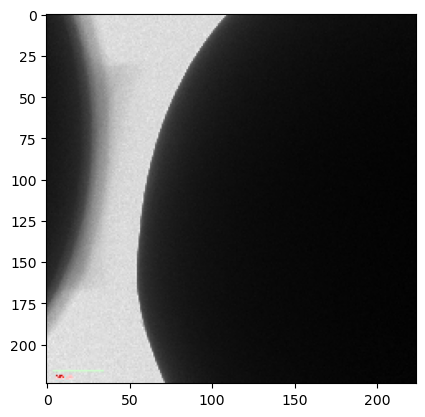

1/1 [==============================] - 0s 99ms/step
the true class is: broken and the predicted class is: broken, and probability is: 7.759033143520355 percent
---------------------------------------------------------
---------------------------------------------------------


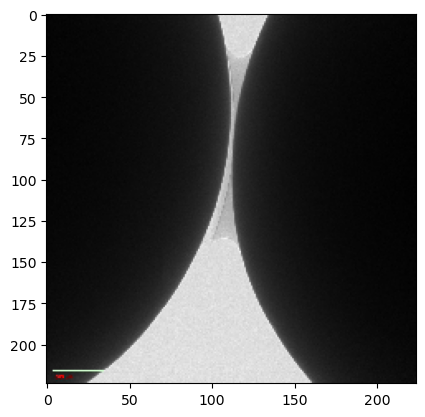

1/1 [==============================] - 0s 97ms/step
the true class is: broken and the predicted class is: broken, and probability is: 25.474441051483154 percent
---------------------------------------------------------
---------------------------------------------------------


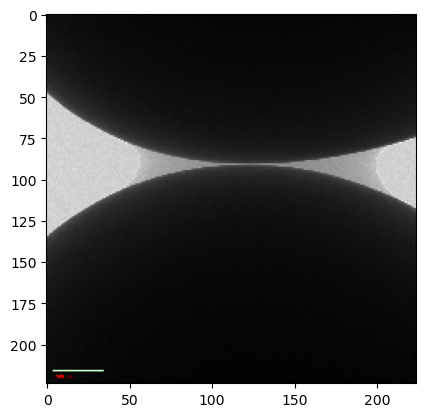

1/1 [==============================] - 0s 99ms/step
the true class is: intact and the predicted class is: intact, and probability is: 96.7695951461792 percent
---------------------------------------------------------
---------------------------------------------------------


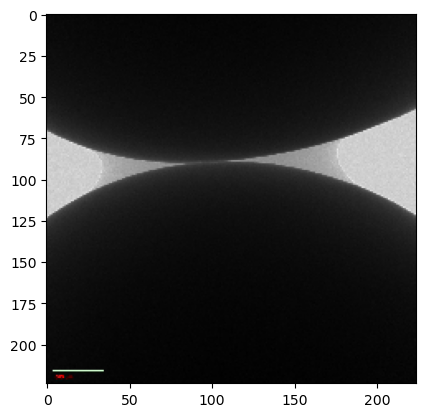

1/1 [==============================] - 0s 102ms/step
the true class is: intact and the predicted class is: intact, and probability is: 98.01632761955261 percent
---------------------------------------------------------
---------------------------------------------------------


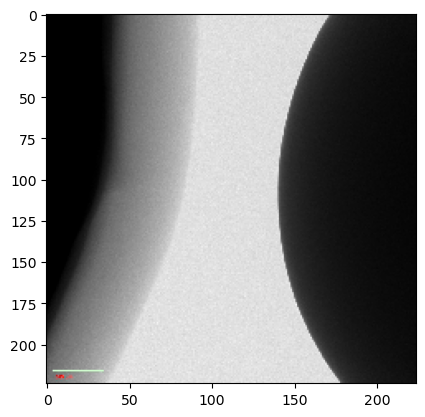

1/1 [==============================] - 0s 106ms/step
the true class is: broken and the predicted class is: broken, and probability is: 1.2488865293562412 percent
---------------------------------------------------------
---------------------------------------------------------


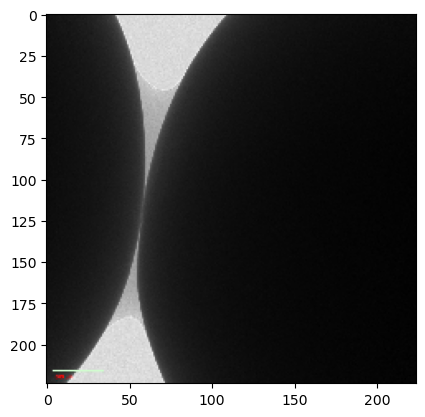

1/1 [==============================] - 0s 103ms/step
the true class is: intact and the predicted class is: intact, and probability is: 91.474449634552 percent
---------------------------------------------------------
---------------------------------------------------------


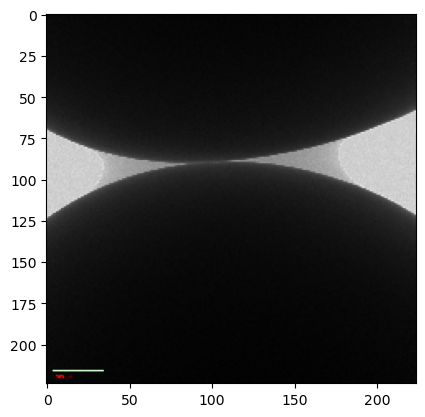

1/1 [==============================] - 0s 100ms/step
the true class is: intact and the predicted class is: intact, and probability is: 98.19254875183105 percent
---------------------------------------------------------
---------------------------------------------------------


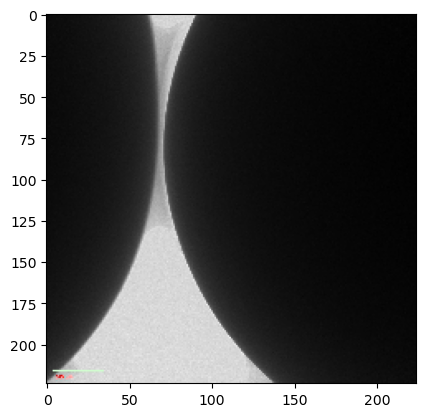

1/1 [==============================] - 0s 101ms/step
the true class is: broken and the predicted class is: broken, and probability is: 18.95257830619812 percent
---------------------------------------------------------
---------------------------------------------------------


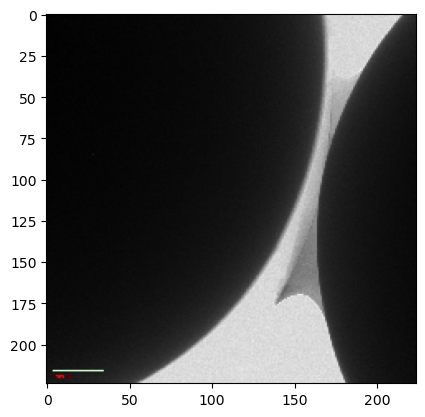

1/1 [==============================] - 0s 96ms/step
the true class is: broken and the predicted class is: broken, and probability is: 8.004985004663467 percent
---------------------------------------------------------


In [58]:
probability_function(resnet_model)